### Github repo
- https://github.com/raphaelvallat/antropy

### Documentation
- https://raphaelvallat.com/antropy/build/html/api.html

| Method | Fractional Gaussian noise H=0.1 | Random | Pure sine wave | Linearly-increasing time-series |
| --- | --- | --- | --- | --- |
| perm_entropy | 0.9986 | 0.9997 | 0.4463 | 0.000 |
| svd_entropy | 0.9080 | 0.9637 | 0.1775 | 0.0053 |
| spectral_entropy | 0.9248 | 0.94 | 1e-28 | 0.26 |
| app_entropy | 2.0906 | 1.8177 | 0.2009 | -0.0010 |
| sample_entropy | 2.0555 | 2.2017 | 0.1633 | 0.0000 |
| petrosian_fd | 1.0283 | 1.0350 | 1.0010 | 1.0000 |
| katz_fd | 7.6540 | 8.1531 | 2.4871 | 1.0000 |
| higuchi_fd | 2.0581 | 2.0013 | 1.0091 | 1.0040 |
| detrended_fluctuation | 0.1262 | 0.5276 | 1.5848 | 2.0390 |

In [7]:
import sys
import numpy as np
from scipy import stats
from scipy.signal import savgol_filter
import pandas as pd
import random

import entropy
import fractal

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [2]:
def progressbar(it, prefix="", size=60, out=sys.stdout):
    '''
    https://stackoverflow.com/questions/3160699/python-progress-bar
    '''
    count = len(it)
    def show(j):
        x = int(size*j/count)
        out.write("%s[%s%s] %i/%i\r" % (prefix, u"#"*x, "."*(size-x), j, count))
        out.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    out.write("\n")
    out.flush()

In [20]:
df_normal = pd.read_csv('ptbdb_normal.csv',header=None).drop(187,axis=1).sample(4000).reset_index(drop=True)
df_abnormal = pd.read_csv('ptbdb_abnormal.csv',header=None).drop(187,axis=1).sample(4000).reset_index(drop=True)

def pre_processor(arr):
    while arr[-1] == 0:
        arr = arr[:-1].copy()
    return savgol_filter(arr, 5, 2, mode='nearest')

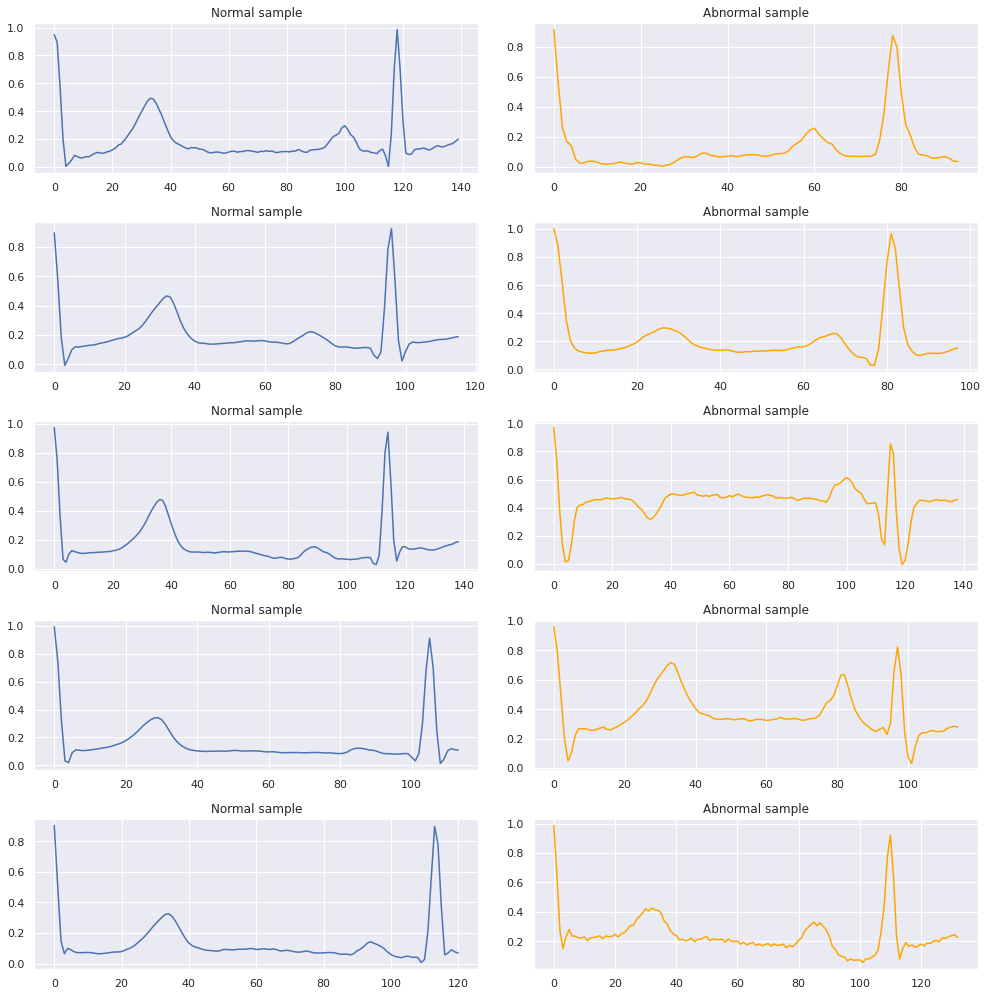

In [21]:
fig,ax=plt.subplots(figsize=(14,14))
c = 1

for idx,idy in zip(random.sample(df_normal.index.tolist(),5),random.sample(df_abnormal.index.tolist(),5)):
    plt.subplot(5,2,c)
    plt.plot(pre_processor(df_normal.iloc[idx].values))
    plt.title('Normal sample')
    plt.subplot(5,2,c+1)
    plt.plot(pre_processor(df_abnormal.iloc[idy].values),color='orange')
    plt.title('Abnormal sample')
    c+=2
plt.tight_layout()

In [22]:
df_FD_normal = pd.DataFrame()
df_FD_abnormal = pd.DataFrame()

print('Processing normal ECG')
for idx in progressbar(range(df_normal.shape[0])):
    signal = pre_processor(df_normal.iloc[idx].values)
    
    df_FD_normal = df_FD_normal.append({
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        'KatzFD': fractal.katz_fd(signal),
        'HiguchiFD': fractal.higuchi_fd(signal),
        'DFA': fractal.detrended_fluctuation(signal)
    }, ignore_index=True)
    
print('Processing abnormal ECG')
for idx in progressbar(range(df_abnormal.shape[0])):
    signal = pre_processor(df_abnormal.iloc[idx].values)
    
    df_FD_abnormal = df_FD_abnormal.append({
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        'KatzFD': fractal.katz_fd(signal),
        'HiguchiFD': fractal.higuchi_fd(signal),
        'DFA': fractal.detrended_fluctuation(signal)
    }, ignore_index=True)

Processing normal ECG
[############################################################] 4000/4000
Processing abnormal ECG
[############################################################] 4000/4000


PermEnt Ttest_indResult(statistic=-44.26248279296391, pvalue=0.0)
SVDEnt Ttest_indResult(statistic=30.370841240855444, pvalue=7.598435259013395e-192)
AppEnt Ttest_indResult(statistic=-31.04649553254006, pvalue=6.48255617809019e-200)
SampleEnt Ttest_indResult(statistic=-33.51771449958379, pvalue=1.362704261152299e-230)
PetrosianFD Ttest_indResult(statistic=-55.32285651963263, pvalue=0.0)
KatzFD Ttest_indResult(statistic=-1.5338339774147618, pvalue=0.1251100552068275)
HiguchiFD Ttest_indResult(statistic=-9.208236047708816, pvalue=4.165941517542755e-20)
DFA Ttest_indResult(statistic=-17.449933894760488, pvalue=5.930363316525407e-67)


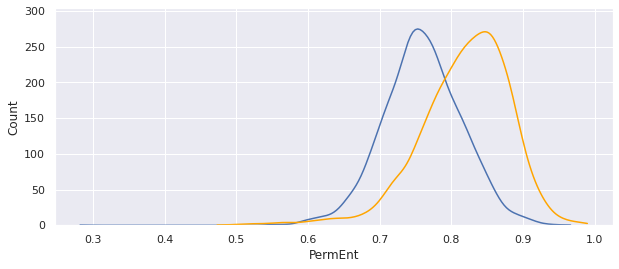

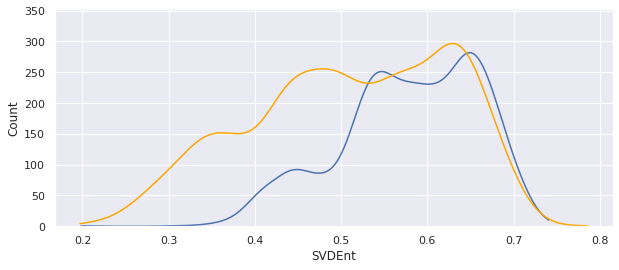

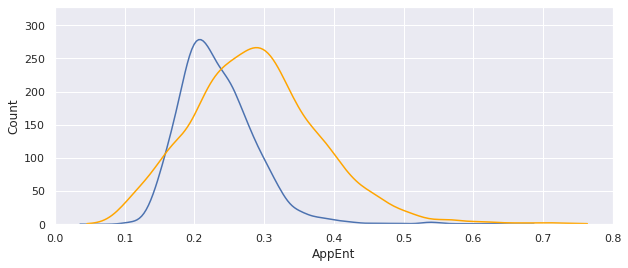

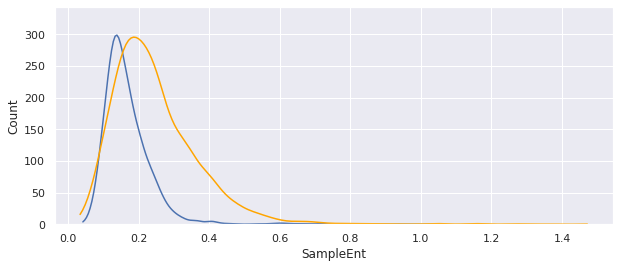

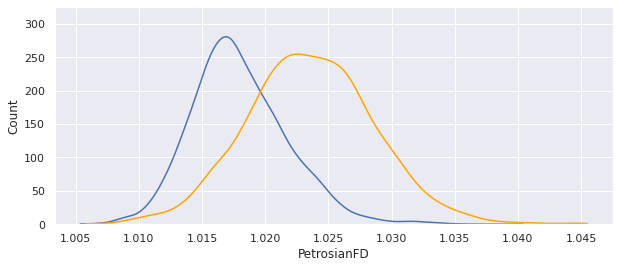

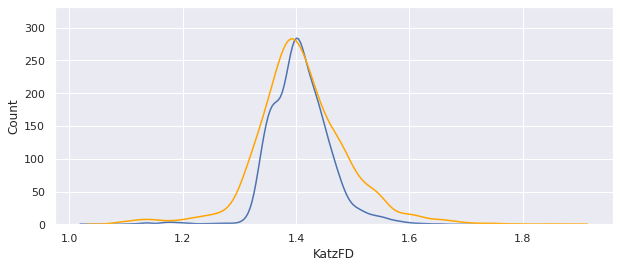

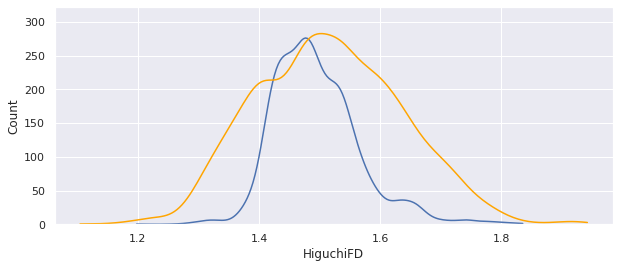

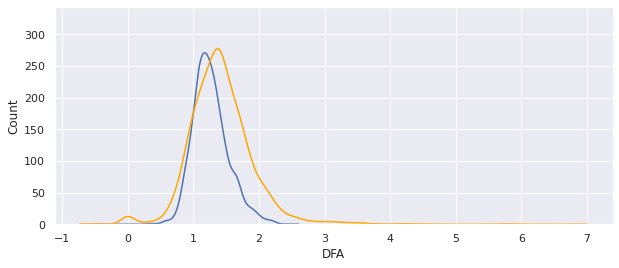

In [23]:
for col in df_FD_normal.columns:
    fig,ax=plt.subplots(figsize=(10,4))
    sns.histplot(df_FD_normal[col],kde=True,alpha=0.,label='normal',linewidth=0)
    sns.histplot(df_FD_abnormal[col],kde=True,color='orange',alpha=0.,label='abnormal',linewidth=0)
    print(col,stats.ttest_ind(df_FD_normal[col], df_FD_abnormal[col]))

In [24]:
df_FD_normal['Label'] = 0
df_FD_abnormal['Label'] = 1

In [25]:
data = df_FD_normal.append(df_FD_abnormal).reset_index(drop=True)

In [32]:
X = data.drop('Label',axis=1).values
y = data['Label'].values.ravel()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

clf = GradientBoostingClassifier()
pipeline = Pipeline(steps = [("CLF",clf)])   
param_grid = {"CLF__n_estimators":[500]} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

# training regressor
print (" > training regressor:")
grid.fit(X_train, y_train.ravel())
clf = grid.best_estimator_

y_pred = clf.predict(X_test)
print("\n > Best grid search:\n",grid.best_params_)

print(classification_report(y_test,y_pred))

 > training regressor:
Fitting 1 folds for each of 1 candidates, totalling 1 fits

 > Best grid search:
 {'CLF__n_estimators': 500}
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       800
           1       0.89      0.87      0.88       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

